In [1]:
%load_ext watermark
%watermark -u -n -t -z -v -p numpy,scipy,neupy,scikit-learn,matplotlib

Loading extensions from ~/.ipython/extensions is deprecated. We recommend managing extensions like any other Python packages, in site-packages.
Last updated: Sun Dec 02 2018 17:27:02 CET

CPython 3.6.0
IPython 6.4.0

numpy 1.14.5
scipy 1.1.0
neupy 0.7.0
scikit-learn 0.20.0
matplotlib 2.2.2


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## VGG19

In [3]:
from neupy import architectures
vgg19 = architectures.vgg19()

/Users/itdxer/.pyenv/versions/3.6.0/envs/neupy36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Download VGG19 pre-trained weights

In [4]:
import os
import sys

CURRENT_DIR = os.path.abspath(os.path.dirname(__name__))
CNN_EXAMPLE_FILES = os.path.join(CURRENT_DIR, '..', 'examples', 'cnn')
VGG19_WEIGHTS_FILE = os.path.join(CNN_EXAMPLE_FILES, 'files', 'vgg19.hdf5')

sys.path.append(CNN_EXAMPLE_FILES)

In [5]:
# requires also modules: requests and tqdm
from imagenet_tools import download_file, load_image, deprocess

In [6]:
import os
from neupy import storage

if not os.path.exists(VGG19_WEIGHTS_FILE):
    download_file(
        url="http://neupy.s3.amazonaws.com/tensorflow/imagenet-models/vgg19.hdf5",
        filepath=VGG19_WEIGHTS_FILE,
        description='Downloading weights')

storage.load(vgg19, VGG19_WEIGHTS_FILE)

## Visualize learned features by different filters in different layers

conv5_4 layer: 100%|██████████| 5/5 [01:36<00:00, 19.29s/it]


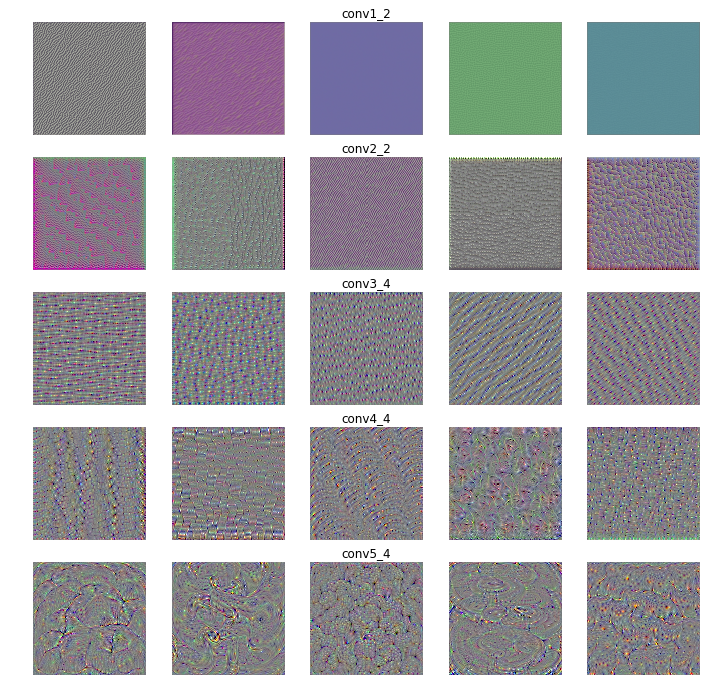

In [7]:
from itertools import product
import numpy as np
import tensorflow as tf
from tqdm import tqdm
from neupy.utils import tensorflow_session

def normalize(input_img_data):
    x = input_img_data[0]
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

layer_names = ('conv1_2', 'conv2_2', 'conv3_4', 'conv4_4', 'conv5_4')
fig, axes = plt.subplots(len(layer_names), 5, figsize=(12, 12))
sess = tensorflow_session()

for i, output_layer_name in enumerate(layer_names):
    desc = "{} layer".format(output_layer_name)
    
    x = tf.placeholder(tf.float32)
    res = vgg19.end(output_layer_name).output(x)
        
    row_axes = axes[i]
    
    for j in tqdm(list(range(5)), desc=desc):
        loss = tf.reduce_mean(res[:, :, :, j])
        grad, = tf.gradients(loss, x)
        grad /= (tf.sqrt(tf.reduce_mean(tf.square(grad))) + 1e-7)

        # we start from a gray image with some noise
        input_img_data = (np.random.random((1, 224, 224, 3)) * 20 + 128).astype(np.float32)

        step = 100.
        for _ in range(20):
            loss_value, grads_value = sess.run([loss, grad], feed_dict={x: input_img_data})
            input_img_data = input_img_data + grads_value * step

        input_img_data = normalize(input_img_data)
        
        row_axes[j].imshow(input_img_data[:, :, ::-1])
        row_axes[j].axis('off')
        
    row_axes[2].set_title(output_layer_name)

## Saliency map

In [8]:
dog = load_image('images/dog.jpg', image_size=(256, 256), crop_size=(224, 224))

/Users/itdxer/.pyenv/versions/3.6.0/envs/neupy36/lib/python3.6/site-packages/ipykernel/__main__.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  from ipykernel import kernelapp as app


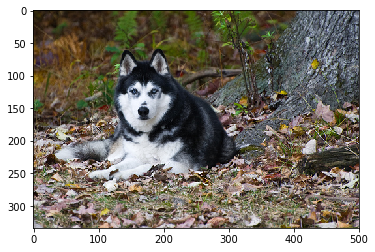

In [9]:
from scipy.misc import imread
plt.imshow(imread('images/dog.jpg'));

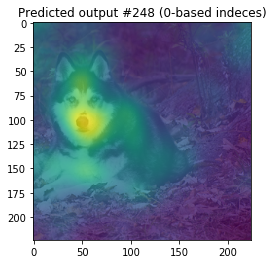

In [16]:
from neupy import plots
plt.imshow(deprocess(dog[0]))
plots.saliency_map(vgg19, dog, alpha=0.8, sigma=10);

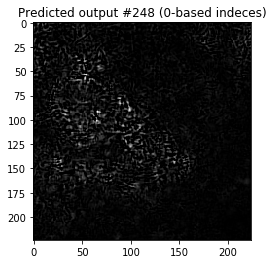

In [18]:
plots.saliency_map(vgg19, dog[0], mode='raw', vmin=0);